# Lab 6

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

Welcome to the sixth lab.

In this lab, we will finally use PyTorch as a deep learning framework.
We will see what are the signs of overfitting, and how to avoid them using regularization.
Then, we will analyze convergence of gradient descent on quadratic
surfaces, and apply the intuition we gain on a practical example,
comparing gradient descent with and without momentum.

## Imports

In [4]:
from operator import itemgetter
import random
import string
from typing import Union, Tuple

import torch
from torch import nn, Tensor
from torch.optim import RMSprop, Adam
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from keras.datasets import imdb

set_matplotlib_formats('png', 'pdf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Exercise 1

In this exercise, we will learn the basic usage of PyTorch,
a popular deep learning library.
We already utilized PyTorch in the exercises before but only to construct matrices and
perform operations on them.

The networks that we will use are small enough that they can run on your personal
computer, but, if you need a GPU, you can try Jupyter on Google Colab
(click [here](https://colab.research.google.com/notebooks/intro.ipynb)).
At the beginning of your session, get a GPU by clicking on "Runtime", then "Change runtime type",
then choose "GPU" as hardware accelerator.

### Loading and preparing the dataset

The dataset that we will be working with is the IMDB dataset,
which is included in Keras.
It contains 50,000 reviews that are highly polarized,
that is, they are unambiguously either 'positive' or 'negative'.
When the data is loaded, the training and test sets will contain 25,000 reviews each.
In both sets, half of the reviews are positive and half are negative.

The `imdb` object returns two tuples with the train and test inputs and targets. For convenience we convert the arrays into lists. The `num_words` argument leads to only the 10k most frequently used words are used. This restricts our vocabulary, the restriction is however sensible as we will see further down below.
Also we use the dictionary to map from the BOW (Link BOW here TBD) that is accessible through the method `.get_word_index()`. Also we reverse it as python has no built in functionality for bidirectional dictionaries.

In [48]:
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=10000)
train_x = [train_x[i] for i in range(len(train_x))]
train_y = [train_y[i] for i in range(len(train_y))]
test_x = [test_x[i] for i in range(len(test_x))]
test_y = [test_y[i] for i in range(len(test_y))]

word2enc = imdb.get_word_index()
enc2word = {v: k for k, v in word2enc.items()}

Let's check a random review!

In [49]:
print(train_x[random.randint(0, len(train_x) - 1)])

[1, 2305, 18, 4, 735, 249, 229, 126, 11, 61, 652, 225, 57, 542, 65, 2, 116, 55, 2320, 486, 34, 175, 817, 614, 48, 25, 28, 117, 532, 1161, 591, 92, 437, 129, 58, 319, 14, 20, 261, 1206, 70, 67, 4, 156, 70, 511, 12, 889, 25, 6903, 103, 149, 12, 3669, 2, 26, 112, 556, 149, 14, 595, 10, 10, 13, 2815, 1206, 10, 10, 92, 67, 14, 20]


This is obviously just the numeric encoding of the sentences. To get something that is in fact readable we need to use the `enc2word` mapping.

In [50]:
print(" ".join([enc2word[enc] for enc in train_x[random.randint(0, len(train_x) - 1)]]))

the as speak comments is inside full may modesty and to talks occasionally film when it justice by br of and difficult your but is on of highlights this of and concept br is dialog and and of ending br du this as working theo br for their is and worse easy rear alone this is banana awry who be 70's is foil and like it craig 1974 of and br of and or of macmurray catch who of mans and isn't also first of and importance figures in same of and for is terms and easy and rock in gang of ending in people for disbelief this of figures all milk talking of 3 br is crying texas easy and and to and door who act more it good planet near this is again road and this is stunning for tries in confrontation give insomnia to identity and past to film is time tragedy low br throw to an beach br and and as you it jersey call not it is very call his br of better sub reveal not br of ten today went what by than in and predictable good and just so efforts purposes this and concept modesty fine by story one in

In [51]:
sorted([key for key in enc2word.keys()])[-4]

88581

Before we feed the reviews to the network, we need to convert them from sequences of
integers to "bag of words" vectors. For example, turning the sequence (3,5,9)
into a 10 dimensional vector gives us (0,0,1,0,1,0,0,0,1,0),
which has a 1 in the positions 3, 5 and 9 and zeros everywhere else.

We only keep the 10,000 most common words, which will be the size of the input vector.

In [53]:
def get_index_vector(sequence: list[int], size: int = 10000) -> list[int]:
# TODO: Encode each sequence to a binary vector as described above.
    torch_init = torch.zeros(1,size)
    torch_init[:,sequence] = 1
    return torch_init
# For now we rely on plain python, thus a "binary vector" is only a list of ints.
# Note: The size argument specifies the maximal number of words in the index vector.
# Note 2: Also take care of potential `None` values.

train_x = [get_index_vector(count_vector) for count_vector in train_x]
test_x = [get_index_vector(count_vector) for count_vector in test_x]

TypeError: list indices must be integers or slices, not list

In [54]:
### Solution 
def get_index_vector(sequence: list[int], size: int = 10000) -> list[int]:
    output_vec = [0 for _ in range(size)]
    for index in sequence:
        if index is None:
            continue
        elif index <= size - 1:
            output_vec[index] = 1
    return output_vec

train_x = [get_index_vector(count_vector) for count_vector in train_x]
test_x = [get_index_vector(count_vector) for count_vector in test_x]

We now have everything ready to built a Pytorch `Dataset` object,
which is recommended for the training process.

We also define `device`. This indicates the location where we would like to process data.
By default tensors are on the CPU. If we have a GPU, we could set `device` to `cuda` to
utilize GPU power. If we have set a device, we can then push a tensor to the desired location
by calling `<tensor>.to(device)`. Tensors can also be created directly on the device
by specifying the `device` argument on tensor initialization.
In this setting device is set to `cuda` if a GPU is
available, otherwise we'll just use the cpu.

Pushing the whole dataset to GPU is often not a possibility due to memory constraints,
but in this exercise the small vectorized IMDB data will only consume around 3GB VRAM.
We could also save memory by reducing the size of the input vector or using sparse tensors.

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class IMDBDataset(Dataset):
    def __init__(self, data: Union[list, Tuple], labels: list, device: torch.device):
        self.data = torch.tensor(data, dtype=torch.float, device=device)
        self.labels = torch.tensor(labels, dtype=torch.float, device=device)

    # We don't need this method necessarily,
    # but it is usually good to have direct access to the dimensions of the dataset.
    @property
    def shape(self) -> Tuple:
        return self.data.shape

    # The `__len__` method should return the number of samples in the dataset.
    # This will later on be used automatically by the data loader.
    def __len__(self) -> int:
        return len(self.labels)

    # Each Dataset needs to implement the `__get_item__` method.
    # The method gets an index and should return the corresponding items.
    # For example index = 5 should return the 5th review and its matching label.
    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
# TODO: Return the correct review and label for the index.
        return self.data[idx], self.labels[idx]

Let’s also create a validation set to monitor the (generalization) performance of the model during training,
by randomly taking the 10,000 samples of the training data and the corresponding labels.
The new training set should contain only the remaining 15,000 samples.

In [56]:
# Get random indices for training and validation split
shuffled_indices = list(range(len(train_x)))
random.seed(42)
random.shuffle(shuffled_indices)

train_idxs = shuffled_indices[:15000]
val_idxs = shuffled_indices[15000:]

# Plain python does not know multi index selection
# We can still use `itemgetter` from the `operator` module to achieve what we want.
val_x = itemgetter(*val_idxs)(train_x)
val_y = itemgetter(*val_idxs)(train_y)

train_x = itemgetter(*train_idxs)(train_x)
train_y = itemgetter(*train_idxs)(train_y)

# We can now finally initialize our PyTorch datasets.
train_dataset = IMDBDataset(train_x, train_y, device)
val_dataset = IMDBDataset(val_x, val_y, device)
test_dataset = IMDBDataset(test_x, test_y, device)

print('Training\t Shape: {}'.format(train_dataset.shape))
print('Validation\tShape: {}'.format(val_dataset.shape))
print('Test\t\tShape: {}'.format(test_dataset.shape))

Training	 Shape: torch.Size([15000, 10000])
Validation	Shape: torch.Size([10000, 10000])
Test		Shape: torch.Size([25000, 10000])


Our data is now ready to be fed to a neural network.

Let's remove the preprocessed data lists to free some RAM:

In [57]:
del train_x
del train_y
del val_x
del val_y
del test_x
del test_y

### Building the network
When deciding on an architecture for a neural network with fully connected layers,
the two key things to consider are:

 - The number of hidden layers in the network
 - The number of neurons in each of the hidden layers

Increasing the depth of the network (that is, adding layers) or increasing the number
of neurons in a given layer will increase the capacity of the network and allow it
to learn more complex non-linear decision boundaries.
However, making the network too large can lead to overfitting.

In practice, deciding on an architecture is an iterative process where
many different networks are trained in order to find a good setting for the
hyperparameters. For this exercise, however, we will use a simple feedforward neural
network with two fully-connected hidden layers consisting of 16 neurons each,
and a single output neuron which outputs the probability of the review being 'positive'.

In PyTorch the `nn` module holds all building blocks that we need.
The `Sequential` module allows us to specify a neural network layer by layer.
A fully connected layer is available as `Linear`.
Simiarly we can import the activation functions as `ReLU` and `Sigmoid`.
We need to push the model to our `device` as well.

In [105]:
input_size = train_dataset.shape[1]

model = nn.Sequential(
    nn.Linear(in_features=input_size, out_features=8),
    nn.Tanh(),
    nn.Linear(in_features=8, out_features=8),
    nn.Tanh(),
    #nn.Linear(in_features=16, out_features= 16),
    #nn.ReLU(),
    nn.Linear(in_features=8, out_features=1),
    nn.Sigmoid()
).to(device)

So, we've built our model. Before we can train the network, however, we must specify:

1. The loss function to use (mean squared error, cross entropy, etc) (Info: [here](https://pytorch.org/docs/stable/nn.html#loss-functions))
2. The optimizer (SGD, Adam, RMSProp, etc.) (Info: [here](https://pytorch.org/docs/stable/optim.html))
3. Any metrics (such as accuracy) used to measure the performance of the model

In [106]:

loss = (
    nn.BCELoss() # Binary Cross Entropy Loss
)

optimizer = (
# TODO: Add the RMSprop optimizer.
# Note: You also need the specify the parameters we want to optimize.
# You get these by calling `model.parameters()`.
    RMSprop(model.parameters(), lr = 0.003)
)

def get_accuracy(prediction: Tensor, target: Tensor) -> float:
    return float(torch.sum(((prediction > 0.5) == target).float()) / len(prediction))

### Fit
We wish to train the network for 20 epochs with batches of size 512.
In contrast to e.g. Keras, in the basic PyTorch approach we need to implement our
training routine mostly from scratch. Luckily PyTorch provides a `DataLoader` utility,
which allows to easily sample from our `Datasets`.
On the downside we still need to manage metrics on our own.

The `train` function below implements one version of a training loop.
The outer `for` loop is for the number of training epochs. The inner `for` loop
iterates over the whole dataset with the help of the `Dataloader`.
The output of the dataloader is dependend on batch size and the definition of the
provided `Dataset`. In our case we specified in the `__get_item__` function of
`IMDBDataset` that a  tuple with one training sample and label should be returned.
The dataloader does batching and collating automatically. This means in the backend
the loader utilizes our `__get_item__` method but presents us batched results.
In other words, for a batch size of 512 the loader gives us a tuple of a 512 x 10000
sample matrix and a label vector of length 512, which we directly unpack into `x` and `y`.

The actual training logic is straightforward. First, we need to do a forward pass and
compute the loss. The optimization itself follows three steps.

1. Make sure all gradients of the parameter tensors are zeroed or None (`optim.zero_grad()`)
2. Backpropagate the error (`loss.backward()`)
3. Apply the gradients using the optimizer (`optim.step`)

The validation loop follows the exact same principles, but obviously we don't do any
optimization steps. The `torch.no_grad()` context manager implies that no gradients
are calculated and no results are stashed on the computation. This makes a significant
difference in speed in larger models.

You may notice that we have set the model in training (`model.train()`) and evaluation
(`model.eval()`) mode. For our simple model this doesn't make a difference, but for some
layers like `Dropout` or `BatchNormalization` this setting triggers different policies.

In [107]:

def train(
    model: nn.Module,
    loss: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataset: Dataset,
    val_dataset: Dataset,
    batch_size: int,
    epochs: int
) -> dict:

    # Define a dict with room for metrics that will be populated during training.
    metrics: dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # The loader allows to shuffle the training data on the fly.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for ep in range(1, epochs + 1):

        batch_losses = []
        predictions = []
        targets = []

        for batch_idx, (x, y) in enumerate(train_loader):

            ############################################
            # TRAINING LOGIC
            ############################################
            # Set the model to training mode
            model.train()

            # Forward pass through the model
            y_hat = model(x).squeeze()
            # Obtain the loss
            batch_loss = loss(y_hat, y)

# TODO: Add backpropagation of the loss and apply the gradients via the optimizer

            # Set all parameter gradients to zero
            optimizer.zero_grad()
            # Backpropogate the error
            batch_loss.backward()
            # Apply gradients
            optimizer.step()

            ############################################

            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)


        ep_train_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_train_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

        batch_losses.clear()
        predictions.clear()
        targets.clear()

        for batch_idx, (x, y) in enumerate(val_loader):

            ############################################
            # VALIDATION LOGIC
            ############################################
            # Set the model to evaluation mode
            model.eval()

            with torch.no_grad():
                # Forward pass through the model
                y_hat = model(x).squeeze()
                # Obtain the loss
                batch_loss = loss(y_hat, y)

# TODO: Do a forward pass and get the batch loss
            ############################################

            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)

        ep_val_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_val_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['val_loss'].append(ep_val_loss)
        metrics['val_acc'].append(ep_val_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.2f}'
              '\tVAL LOSS:\t {:.5f}\tVAL ACCURACY:\t {:.2f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_val_loss, ep_val_acc), end='\r')

    return metrics

metrics = train(
    model=model,
    loss=loss,
    optimizer=optimizer,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=15,
    batch_size=125
)

Let's visualize the training progress.
We can utilize the `metrics` that are returned from our `train` method.

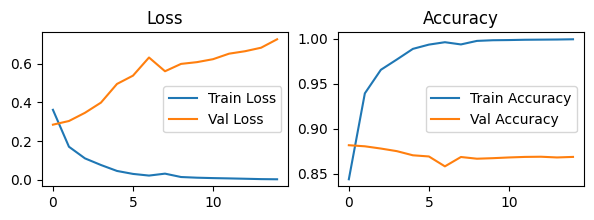

In [108]:

def get_training_progress_plot(
        train_losses: list[float],
        train_accs: list[float],
        val_losses: list[float],
        val_accs: list[float],
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

    ax1.set_title('Loss')
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.legend()
    #ax1.set_yscale('log')

    ax2.set_title('Accuracy')
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Val Accuracy')
    ax2.legend()

get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['val_loss'],
    metrics['val_acc'],
)

As expected, the training loss decreases with each epoch (and training accuracy increases).
However, the validation loss decreases initially and then begins to increase after
the first few epochs epochs. Therefore, the network has overfit.

### Evaluate
Let's evaluate the performance of the model on the test set:

In [109]:

def evaluate(model: nn.Module, test_dataset: Dataset, batch_size: int = 512) -> dict:
    batch_losses: list = []
    predictions: list = []
    targets: list = []

    for x, y in DataLoader(test_dataset, batch_size):
# TODO: Do a forward pass and get the batch loss
        y_hat = model(x).squeeze()
        batch_loss = loss(y_hat, y)
        ############################################

        batch_losses.append(batch_loss)
        predictions.append(y_hat.detach())
        targets.append(y)

    eval_loss = float(torch.mean(torch.stack(batch_losses)))
    eval_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

    return {'test_loss': eval_loss, 'test_acc': eval_acc}

eval_metrics = evaluate(model, test_dataset)
print(eval_metrics)

{'test_loss': 0.8274237513542175, 'test_acc': 0.8496800065040588}


Our simple model does reasonably well. It achieves an accuracy of around 85-88%.

### Predict
Finally, to generate the likelihood of the reviews being positive, we only need to
forward data through our fitted model:

In [111]:
test_x = test_dataset.data[:10]
test_y = test_dataset.labels[:10]
predictions = model(test_x)

for i in range(len(test_x)):
    # print true and prediction but with decimal notation instead of scientific notation
    print('{} | TRUE: {} | PRED {:.2f}'.format(i, int(test_y[i]), float(predictions[i])))

0 | TRUE: 0 | PRED 0.00
1 | TRUE: 1 | PRED 1.00
2 | TRUE: 1 | PRED 0.42
3 | TRUE: 0 | PRED 1.00
4 | TRUE: 1 | PRED 1.00
5 | TRUE: 1 | PRED 0.92
6 | TRUE: 1 | PRED 1.00
7 | TRUE: 0 | PRED 0.00
8 | TRUE: 0 | PRED 1.00
9 | TRUE: 1 | PRED 1.00


Now play around with the code by adding and deleting layers, changing the hidden activation, optimizer, learning rate, batch-size, etc.

### Conclusion
Here's what you should take away from this example:

 - You usually need to do quite a bit of preprocessing on your raw data in order to be
able to feed it -- as tensors -- into a neural network. Encoding the words as BOW vectors
is only the tip of the iceberg.
 - Stacks of dense layers with `ReLU` activations can solve a wide range of problems
(including sentiment classification), and you'll likely use them frequently.
 - As they get better on their training data, neural networks eventually start
_overfitting_ and end up obtaining increasingly worse results on data they have never
seen before. Be sure to always monitor performance on data that is outside of the training set.


## Exercise 2
In this exercise, we will look at a couple of different methods to regularize a neural
network in order to prevent overfitting.

Plotting the validation loss is a simple way to determine whether the network has
overfit. During the first few epochs of training, both the training loss and the
validation loss tend to decrease in tandem but after a certain point, the validation
loss starts to increase while the training loss continues to decrease.
It is at this point that the network begins to overfit.

### Training multiple networks

In order to get a feel for the overfitting behaviour of neural networks,
we will train 3 different architectures and observe the training and validation losses.

Create the first model with two hidden layers, each with 16 units and ReLU activation.

In [117]:
input_size = train_dataset.shape[1]

original_model = nn.Sequential(
                    nn.Linear(in_features=input_size, out_features=16),
                    nn.ReLU(),
                    nn.Linear(in_features=16, out_features=16),
                    nn.ReLU(),
                    nn.Linear(in_features=16, out_features=16),
                    nn.ReLU(),
                    nn.Linear(in_features=16, out_features=1),
                    nn.Sigmoid()
    ).to(device)

Our second model will be similar to the first but it will be much smaller.
Reduce the number of neurons in the hidden layers from 16 to 4, and keep everything
else unchanged.

In [118]:

smaller_model = nn.Sequential(
                    nn.Linear(in_features=input_size, out_features=4),
                    nn.ReLU(),
                    nn.Linear(in_features=4, out_features=4),
                    nn.ReLU(),
                    nn.Linear(in_features=4, out_features=4),
                    nn.ReLU(),
                    nn.Linear(in_features=4, out_features=1),
                    nn.Sigmoid()
    ).to(device)

We now train both networks network using our `train` function for 20 epochs using a
batch size of 512. Remember to use a separate validation dataset.
We also need to initialize a new optimizer for the model.

In [119]:
print('Training original model...')
original_model_metrics = train(
    model=original_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(original_model.parameters()),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

print('Training smaller model...')
smaller_model_metrics = train(
    model=smaller_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(smaller_model.parameters()),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

Training original model...
Training smaller model...0.063	TRAIN ACCURACY:	0.98	VAL LOSS:	 0.66599	VAL ACCURACY:	 0.88


### Plotting the losses

Let's compare the losses over the course of training.

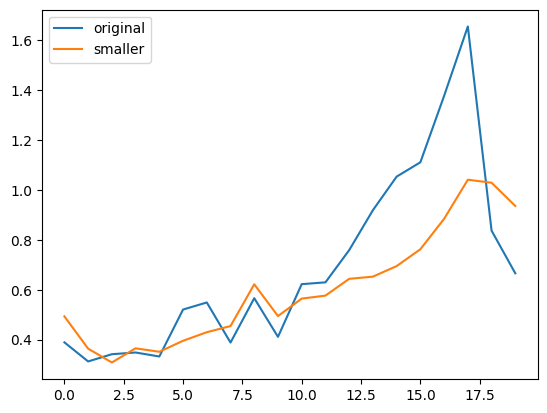

In [120]:

def compare_losses_plot(
        first_losses: list[float],
        second_losses: list[float],
        first_loss_label: str,
        second_loss_label: str
) -> None:
    plt.plot(first_losses, label=first_loss_label)
    plt.plot(second_losses, label=second_loss_label)
    plt.legend()
    plt.show()

compare_losses_plot(
    original_model_metrics['val_loss'],
    smaller_model_metrics['val_loss'],
    'original',
    'smaller'
)

As you can see, the smaller network starts overfitting later than the original one and
its performance degrades much more slowly once it starts overfitting.

### Third model
Now we build a third neural network that is even bigger than the original network.
If the previous plot is any indication, this new network should overfit even worse
than the original model.

In [121]:

bigger_model = nn.Sequential(
                    nn.Linear(in_features=input_size, out_features=512),
                    nn.ReLU(),
                    nn.Linear(in_features=512, out_features=512),
                    nn.ReLU(),
                    nn.Linear(in_features=512, out_features=512),
                    nn.ReLU(),
                    nn.Linear(in_features=512, out_features=1),
                    nn.Sigmoid()
    ).to(device)
# TODO: Create a bigger network with 2 hidden layers of size 512 and push it to `device`.

Let's train this network:

In [122]:
print('Training bigger model...')
bigger_model_metrics = train(
# TODO: Fill in the correct parameters for the function
# TODO: Also use the `Adam` optimizer if there are convergence issues.
    model=bigger_model,
    loss=nn.BCELoss(),
    optimizer=Adam(bigger_model.parameters()),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

Training bigger model...


Here's how the bigger network fares compared to the reference one:

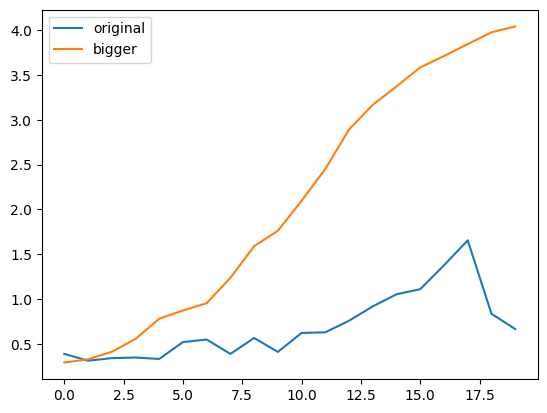

In [123]:
compare_losses_plot(
    original_model_metrics['val_loss'],
    bigger_model_metrics['val_loss'],
    'original',
    'bigger'
)

The bigger network starts overfitting almost right away, after just one epoch
and overfits severely. Its validation loss is also very noisy.

Let's plot the training losses:

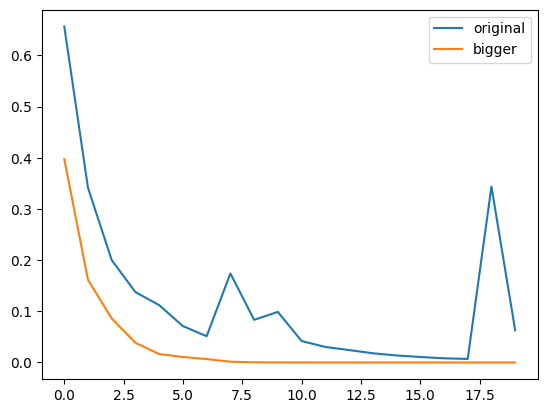

In [124]:
compare_losses_plot(
    original_model_metrics['train_loss'],
    bigger_model_metrics['train_loss'],
    'original',
    'bigger'
)

As you can see, the bigger network gets its training loss near zero very quickly.
The more capacity the network has, the quicker it will be able to model the training
data (resulting in a low training loss), but the more susceptible it is to overfitting
(resulting in a large difference between the training and validation loss).

### Adding weight regularization

Regularizing a model in PyTorch can be done over the additional `weight_decay`
argument in the optimizer function. By setting a coefficient there, the linked
parameters will have a L2 penalty.

In the following we redeclare the original model, set an optimizer with
`weight_decay` coefficient of 0.001 and fit it.

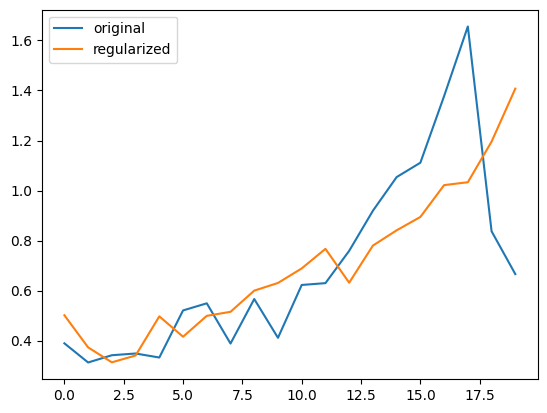

In [131]:
regularized_model = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1),
        nn.Sigmoid()
).to(device)

regularized_model_metrics = train(
    model=regularized_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(regularized_model.parameters(), weight_decay=0.00003),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

compare_losses_plot(
    original_model_metrics['val_loss'],
    regularized_model_metrics['val_loss'],
    'original',
    'regularized'
)

As you can see, the regularized model does not overfit as much,
even though both models have the same number of parameters.
Feel free to play with the regularization strength to get a feel on how different
settings affect learning. When is regularization preventing the network from
learning anything at all? When is regularization so weak it does not make a difference?

### Dropout regularization
Dropout is a very popular technique to regularize neural nets.
It works by randomly turning off (or "dropping out")  the input/hidden neurons in a
network. This means that every neuron is trained on a different set of examples.
Note that dropout is, in most cases, only used during training time.
At test time, all units are used with their activations scaled down by the dropout rate
to account for the fact that all neurons were used for the prediction.
Normally, dropout is not applied to the inputs.

In torch, dropout is implemented as its own separate layer (`Dropout`) that takes as
input the probability to _drop_ units. To apply dropout to a layer, place a `Dropout` after
it while stacking layers. The dropout will be ignored if the model is in `eval` mode.
Luckily, we already set the correct modes for training and evaluation in our `train`
function.

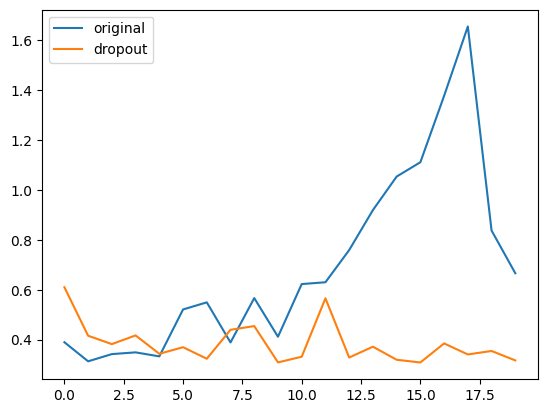

In [135]:
dropout_model = nn.Sequential(
# TODO: Keep the structure of the original model,
# but add dropout after the hidden layers with prob=0.5
    nn.Linear(in_features=input_size, out_features=16),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=16, out_features=16),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=16, out_features=1),
    nn.Sigmoid()
).to(device)

dropout_model_metrics = train(
    model=dropout_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(dropout_model.parameters(), weight_decay=0.001),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

compare_losses_plot(
    original_model_metrics['val_loss'],
    dropout_model_metrics['val_loss'],
    'original',
    'dropout'
)

Once again, we see a marked improvement in the new model.

### Early Stopping

Previously, we were training the network and checking _after training_ when it started
to overfit. But another very popular method to regularize a network is to stop
training earlier than the specified number of epochs, by checking when the validation
loss starts to increase.

There are no out of box utilities to achieve this kind of behavior, so we will adjust
the training loop accordingly.
We also add the `patience` argument to the function.
`patience` indicates how many epochs to wait for an improvement of the validation loss.
If there is no improvement for more than `patience` epochs, training is interrupted.

NOTE: We only implement a very naive method of early stopping. Usually you would
need to roll back the weights to the epoch, which had the last improvement (early
stopping epoch minus patience). However, checkpointing and caching weights is out
of scope of this exercise.

In [137]:

def train(
    model: nn.Module,
    loss: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataset: Dataset,
    val_dataset: Dataset,
    batch_size: int,
    epochs: int,
    early_stopping: bool = False,
    patience: int = 2,
) -> dict:

    # Define a dict with room for metrics that will be populated during training.
    metrics: dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # Track how often in a row no improvements happen
    early_stopping_strikes = 0

    # The loader allows to shuffle the training data on the fly.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for ep in range(1, epochs + 1):

        batch_losses = []
        predictions = []
        targets = []

        for batch_idx, (x, y) in enumerate(train_loader):
            model.train()

            y_hat = model(x).squeeze()
            batch_loss = loss(y_hat, y)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)


        ep_train_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_train_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

        batch_losses.clear()
        predictions.clear()
        targets.clear()

        for batch_idx, (x, y) in enumerate(val_loader):
            model.eval()

            with torch.no_grad():
                y_hat = model(x).squeeze()
                batch_loss = loss(y_hat, y)

            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)

        ep_val_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_val_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['val_loss'].append(ep_val_loss)
        metrics['val_acc'].append(ep_val_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.2f}'
              '\tVAL LOSS:\t {:.5f}\tVAL ACCURACY:\t {:.2f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_val_loss, ep_val_acc), end='\r')

        ###############################################################
        # EARLY STOPPING
        ###############################################################
        if early_stopping and ep > 1:
            if metrics['val_loss'][-2] <= metrics['val_loss'][-1]:
                early_stopping_strikes += 1
            else:
                early_stopping_strikes = 0
        if early_stopping_strikes >= patience:
            break
# TODO: Abort training when `early_stopping_strikes` has reached `patience`.

    return metrics

Let's train the dropout model with early stopping and patience of 2.:

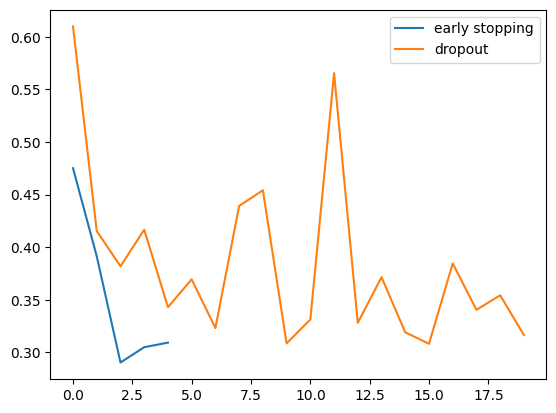

In [138]:
early_dropout_model = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=16),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=16, out_features=1),
        nn.Sigmoid()
).to(device)

early_dropout_model_metrics = train(
    model=early_dropout_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(early_dropout_model.parameters()),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512,
    early_stopping=True,
    patience=2
)

compare_losses_plot(
    early_dropout_model_metrics['val_loss'],
    dropout_model_metrics['val_loss'],
    'early stopping',
    'dropout'
)

As you can see, the early stopping callback worked
and the model was trained for only a few epochs.
Now, evaluate this model on the test data:

In [139]:

# TODO: Evaluate this model on the test data and print the metrics.
print(evaluate(early_dropout_model, test_dataset))

{'test_loss': 0.3441363573074341, 'test_acc': 0.8665599822998047}


As you can see, the loss is close to the lowest loss in the graph.

The take-home message for this exercise is: large neural networks can easily overfit,
especially with small training sets. This means that the network learns spurious patterns
 that are present in the training data and, therefore, fails to generalize to unseen examples.
 In such a scenario, your options are:

 1. Get more training data
 2. Reduce the size of the network
 3. Regularize the network

## Exercise 3

Consider an error function of the form:

\begin{equation}
E=\frac 1 2 \lambda_1 x_1^2+\frac 1 2 \lambda_2 x_2^2
\end{equation}

With $\lambda_1\geq 0$ and $\lambda_2\geq 0$. First, show that the global minimum of
$E$ is at $x_1=x_2=0$, then find the matrix $\textbf{H}$ such that $E=1/2 \cdot \textbf{x}^T\textbf{H}\textbf{x}$.
Show that the two eigenvectors $\textbf{u}_1$ and $\textbf{u}_2$ of this matrix are
axis-aligned, and have $\lambda_1$ and $\lambda_2$ as eigenvalues.

Note that any vector $\textbf{x}$ can be expressed as

\begin{equation}
\textbf{x}=\sum_i \alpha_i\textbf{u}_i
\end{equation}
where $\alpha_i$ is the distance from the origin to $\textbf{x}$ along the $i$-th axis
(assuming the eigenvectors have unit length). Now find the gradient of $E$ with respect
to $\textbf{x}$, and express it in terms of $\alpha_i$, $\lambda_i$ and $\textbf{u}_i$.

Then, use this gradient to perform one step of gradient descent, i.e. compute

\begin{equation}
\textbf{x}^\prime=\textbf{x}-\eta\nabla_{\textbf{x}}E
\end{equation}

And show that it can be reexpressed using 

\begin{equation}
\alpha^\prime_i=(1-\eta\lambda_i)\alpha_i
\end{equation}

Which means that the distances from the origin to the current location evolve
independently for each axis, and at every step the distance along the direction
$\textbf{u}_i$ is multiplied by $(1-\eta\lambda_i)$. After $T$ steps, we have

\begin{equation}
\alpha^{(T)}_i=(1-\eta\lambda_i)^T\alpha^{(0)}_i
\end{equation}
So that, as long as $|1-\eta\lambda_i|<1$ for every $i$, $\textbf{x}^{(T)}$ converges
to the origin as $T$ goes to infinity.

Now, find the largest learning rate that guarantees convergence along all directions
and show that, when using this learning rate, the slowest direction of convergence is
along the eigenvector with the smallest eigenvalue. Also show that the rate of
convegence along this direction is:

\begin{equation}
\left(1-2\frac{\lambda_{\text{min}}}{\lambda_{\text{max}}}\right)
\end{equation}

Where $\lambda_{\text{min}}$ and $\lambda_{\text{max}}$ are the smallest and largest
eigenvalues of $\textbf{H}$.

This exercise shows that the largest eigenvalue determines the maximum learning rate,
and that the relationship between smallest and largest eigenvalues determines the speed
of convergence. Note that the ratio $\lambda_{\text{max}}/\lambda_{\text{min}}$ is known
as the _condition number_ of $\textbf{H}$, and plays an important role in numerical
analysis. Matrices with large condition number make optimization algorithms slower and/or
more imprecise.


## Exercise 4
In this exercise we play a bit with the quadratic error surfaces that we analyzed in the
previous exercise. We will apply the insights we got, and test different forms of
gradient descent. The purpose is to get an intuitive feeling for how these things work,
and for this some playful interaction is required from your side.

Remember that the error function was:

\begin{equation}
E=\frac 1 2 \lambda_1 x_1^2+\frac 1 2 \lambda_2 x_2^2
\end{equation}

We first create an object to compute $E$ and its gradient:

In [140]:

class Function:
    def __init__(self, lambda_1: float, lambda_2: float):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2

    def __call__(self, x: Tensor) -> Tensor:
        return self.lambda_1 * x[:, 0]**2 / 2 + self.lambda_2 * x[:, 1]**2 / 2

    def grad(self, x:Tensor) -> Tensor:
        return torch.stack([
# TODO: Compute the two components of the gradient of E at x
            self.lambda_1 * x[:,0],
            self.lambda_2 * x[:,1]
        ]).T

    def plot(self, show: bool = False):
        grid_range = torch.linspace(-5, 5, 50)
        grid_x, grid_y = torch.meshgrid(grid_range, grid_range)
        grid_data = torch.stack([grid_x.flatten(), grid_y.flatten()]).T
        plt.contour(grid_x, grid_y, self(grid_data).view(grid_x.shape))
        if show:
            plt.show()

quad_function = Function(lambda_1=1, lambda_2=10)

And we visualize a contour plot of the surface:

c:\Users\esual\Locals\local_repos\venvLmu\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


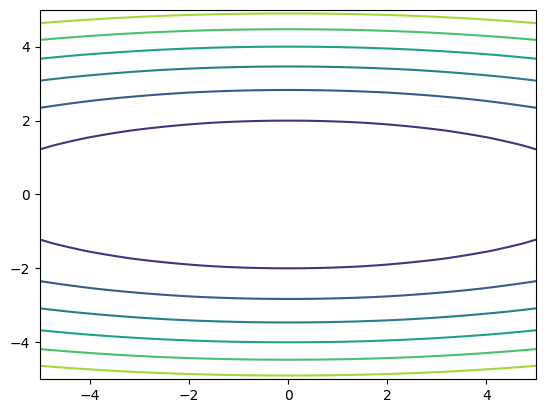

In [141]:
quad_function.plot()

We now create a vanilla gradient descent optimizer that returns all points
visited during the process:

In [144]:
def do_gradient_descent(x: Tensor, func_obj: Function, max_steps: int, lr: float) -> Tensor:
    path: list = [x.clone()]
    for _ in range(max_steps):
# TODO: Modify `x` performing one step of gradient descent
        x -= lr * func_obj.grad(x)
        path.append(x.clone())
    return torch.cat(path)

hist_slow = do_gradient_descent(torch.tensor([[4., 4.]]), quad_function, 10, 0.05)
hist_fast = do_gradient_descent(torch.tensor([[4., 4.]]), quad_function, 10, 0.15)

And a function that plots several traces together, so that we can compare them:

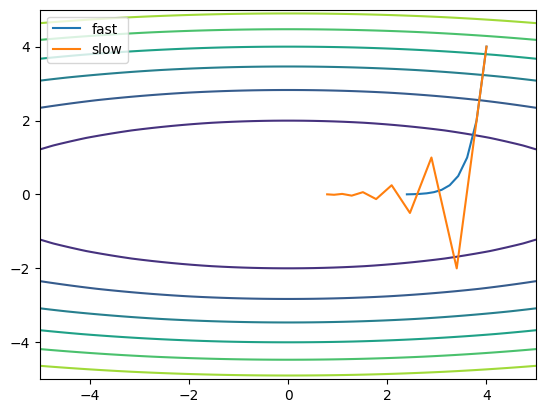

In [145]:
def plot_histories(histories: list[Tensor], labels: list[str]) -> None:
    for history, label in zip(histories, labels):
        plt.plot(history[:, 0], history[:, 1], label=label)
    plt.legend()

quad_function.plot()
plot_histories([hist_slow, hist_fast], ['fast', 'slow'])

Now, recall from the previous exercise that the learning rate cannot be larger than
$2\lambda_{\text{min}}/\lambda_{\text{max}}$.
Compute this upper bound for the example here, use it to optimize the error starting
from $\textbf{x}=|4,4|^T$, and plot the resulting trajectory.
What can you notice?
Try to slightly reduce it and increase it, and verify that when it is larger than the
upper bound, the procedure diverges.

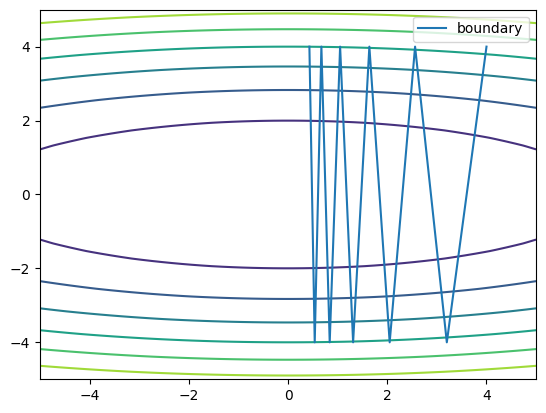

In [146]:
max_learning_rate =(
# TODO: Compute the maximum learning rate possible in this case.
    2 / max(quad_function.lambda_1, quad_function.lambda_2)
)

hist_max = do_gradient_descent(torch.tensor([[4., 4.]]), quad_function, 10, max_learning_rate)
quad_function.plot()
plot_histories([hist_max], ['boundary'])

Now try to change the eigenvalues so as to increase the condition number
and verify that convergence becomes slower as the condition number increases:

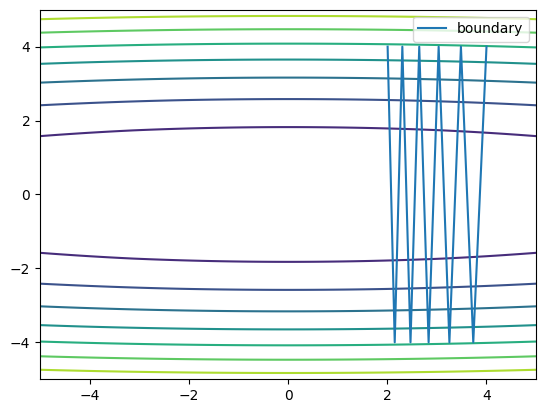

In [174]:
quad_function = Function(lambda_1=1, lambda_2=30)

max_learning_rate =(
# TODO: Compute the maximum learning rate possible in this case.
    2/30
)
hist_max = do_gradient_descent(torch.tensor([[4., 4.]]), quad_function, 10, max_learning_rate)
quad_function.plot()
plot_histories([hist_max], ['boundary'])

Finally, modify the optimizer to use momentum, and verify that convergence becomes faster:

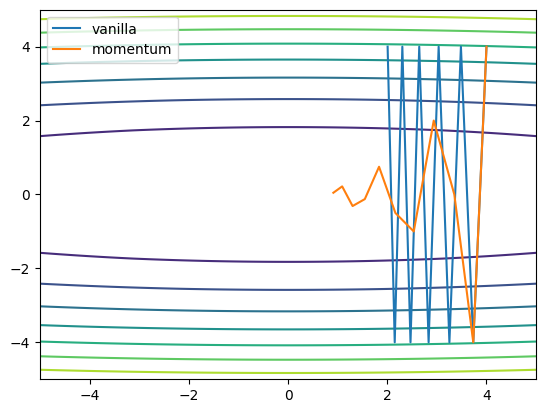

In [178]:
def do_momentum_gd(
        x: Tensor, func_obj: Function, max_steps: int, lr: float, momentum: float) -> Tensor:
    path: list = [x.clone()]
    velocity = torch.zeros(x.shape)
    for _ in range(max_steps):
# TODO: Modify `x` and the velocity performing one step of gd with momentum.
        velocity = momentum * velocity - lr * func_obj.grad(x)
        x += velocity
        path.append(x.clone())
    return torch.cat(path)

momentum = (
            0.5
)

hist_momentum = do_momentum_gd(
    x=torch.tensor([[4., 4.]]),
    func_obj=quad_function,
    max_steps=10,
    lr=max_learning_rate,
    momentum=momentum
)
quad_function.plot()
plot_histories([hist_max, hist_momentum], ['vanilla', 'momentum'])

Now explore the convergence behavior as momentum and learning rate change.
Does momentum bring any improvement when the condition number is one
(i.e. the eigenvalues are identical)?

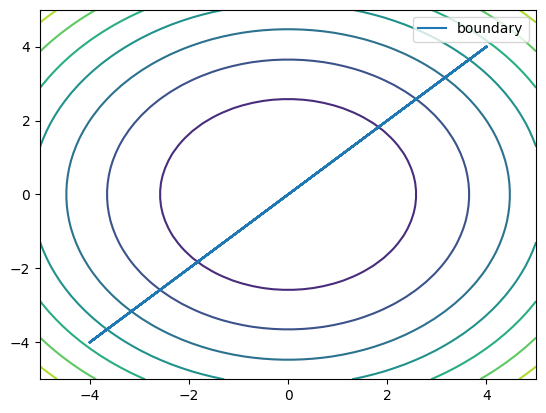

In [179]:
quad_function = Function(lambda_1=30, lambda_2=30)

max_learning_rate =(
# TODO: Compute the maximum learning rate possible in this case.
    2/30
)
hist_max = do_gradient_descent(torch.tensor([[4., 4.]]), quad_function, 10, max_learning_rate)
quad_function.plot()
plot_histories([hist_max], ['boundary'])

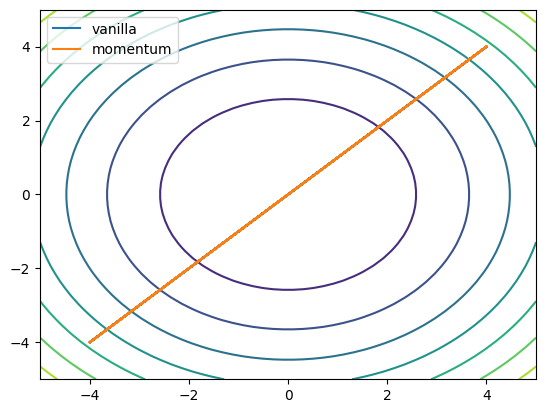

In [180]:
momentum = (
            1
)

hist_momentum = do_momentum_gd(
    x=torch.tensor([[4., 4.]]),
    func_obj=quad_function,
    max_steps=10,
    lr=max_learning_rate,
    momentum=momentum
)
quad_function.plot()
plot_histories([hist_max, hist_momentum], ['vanilla', 'momentum'])